In [2]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils import graph_tools, qaoaCUDAQ as q, graph_tools
import networkx as nx
import time

cudaq.set_target("nvidia")

In [28]:
def po_normalize(B, P, ret, cov):
    P_b = P / B
    ret_b = ret * P_b
    cov_b = np.diag(P_b) @ cov @ np.diag(P_b)
    
    n_max = np.int32(np.ceil(np.log2(B/P)))
    n_qs = np.cumsum(n_max)
    n_qs = np.insert(n_qs, 0, 0)
    n_qubit = n_qs[-1]
    C = np.zeros((len(P), n_qubit))
    for i in range(len(P)):
         for j in range(n_max[i]):
              C[i, n_qs[i] + j] = 2**j

    P_bb = C.T @ P_b
    ret_bb = C.T @ ret_b
    cov_bb = C.T @ cov_b @ C
    return P_bb, ret_bb, cov_bb, int(n_qubit)

def ret_cov_to_QUBO(ret: np.ndarray, cov: np.ndarray, P: np.ndarray, lamb: float, q:float) -> np.ndarray:
    di = np.diag(ret + lamb * (P*P + 2*P))
    mat = 2 * lamb * np.outer(P, P) + q * cov
    return di - mat

def qubo_to_ising(qubo: np.ndarray, lamb: float) -> cudaq.SpinOperator:
    spin_op = lamb
    for i in range(qubo.shape[0]):
        for j in range(qubo.shape[1]):
                if i != j:
                    spin_op += qubo[i, j] * ((spin.i(i) - spin.z(i)) / 2 * (spin.i(j) - spin.z(j)) / 2)
                else:
                    spin_op += qubo[i, j] * (spin.i(i) - spin.z(i)) / 2
    return spin_op

In [29]:
B = 100
ret = np.array([1.1, 1.3, 1.2])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([20, 15, 30])
lamb = 20 # Budget Penalty
q = 0.5 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

B = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(B, lamb)


[[1.25989105 1.11760126 0.43625533]
 [1.11760126 1.37546794 1.15753994]
 [0.43625533 1.15753994 1.87239055]]
n_qubit: 8


In [30]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [31]:
print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

     ╭───╮                                                               ╭───╮»
q0 : ┤ h ├──●───────────────●────────────────────────────────────────────┤ x ├»
     ├───┤╭─┴─╮╭─────────╮╭─┴─╮                                          ╰─┬─╯»
q1 : ┤ h ├┤ x ├┤ rz(0.2) ├┤ x ├──●───────────────●─────────────────────────┼──»
     ├───┤╰───╯╰─────────╯╰───╯╭─┴─╮╭─────────╮╭─┴─╮                       │  »
q2 : ┤ h ├─────────────────────┤ x ├┤ rz(0.2) ├┤ x ├──●───────────────●────┼──»
     ├───┤                     ╰───╯╰─────────╯╰───╯╭─┴─╮╭─────────╮╭─┴─╮  │  »
q3 : ┤ h ├──────────────────────────────────────────┤ x ├┤ rz(0.2) ├┤ x ├──●──»
     ╰───╯                                          ╰───╯╰─────────╯╰───╯     »

################################################################################

╭─────────╮╭───╮╭─────────╮                                               »
┤ rz(0.2) ├┤ x ├┤ rx(0.2) ├──●───────────────●────────────────────────────»
╰─────────╯╰─┬─╯├─────────┤╭─┴─╮╭─────────╮╭─

In [32]:
idx = 3
layer_count = 4

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [0.3568976411430482, 0.26026504566684094, -0.3734334249048788, -0.07687543613958137, -0.12009217238968428, 0.0936306560072791, 0.09499236260745858, 0.1647801535897685]


In [33]:
expectations = []

def cost_func(parameters):
    return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [34]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = 47.399558996389956
optimal_parameters = [0.7839458800088694, 0.7791875161124113, -1.1748736560004238, -0.7816853971183237, -0.7910033278741634, -0.3957358234367774, 0.7913587850627176, 0.7886948429593212]
Time taken =  51.715439796447754


In [35]:
shots_count = int(1e7)
print(f"Sampling {shots_count} times...")
result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)



Sampling 10000000 times...
Finding the best solution...
01010101 5002964 0.5002964
10101010 4995878 0.4995878


In [36]:
assert False

AssertionError: 

In [37]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

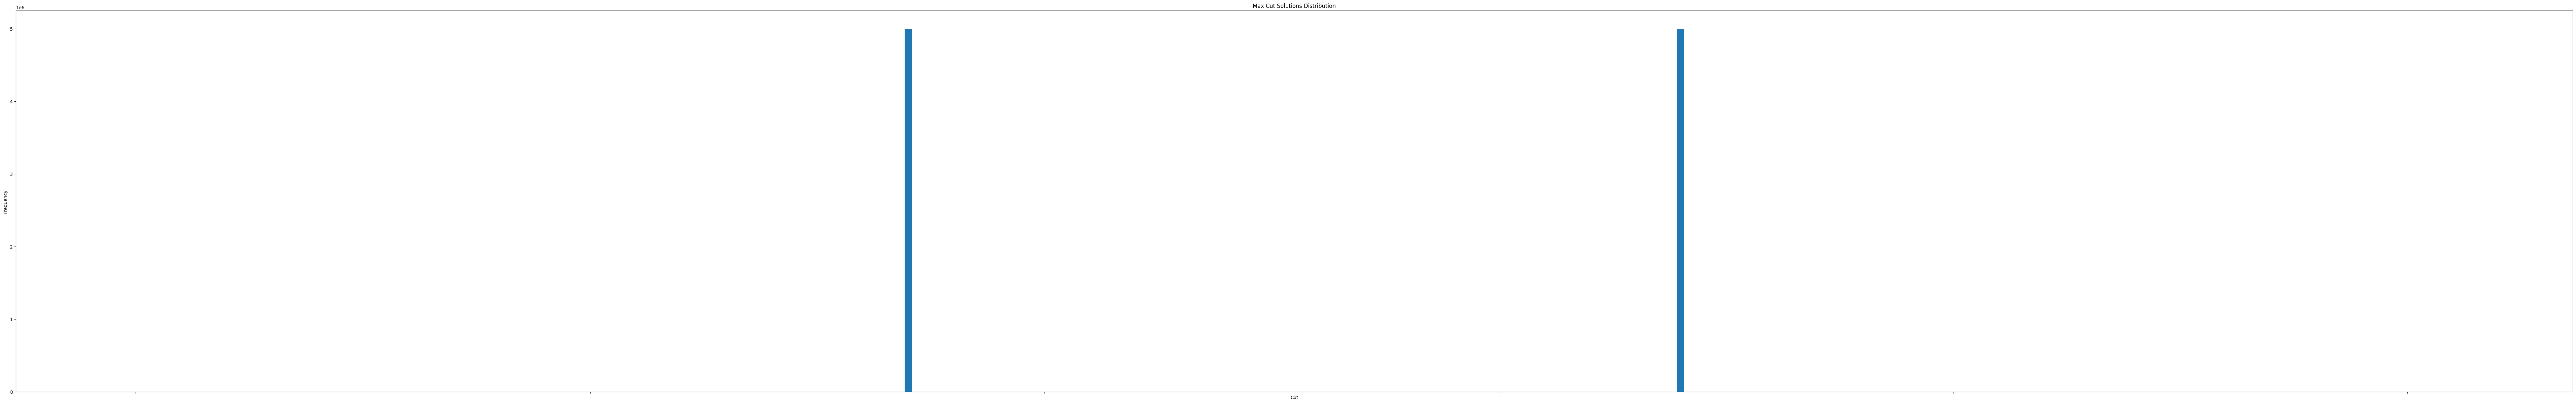

In [38]:
plt.figure(figsize=(100, 15))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Max Cut Solutions Distribution')
plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Loading expectations from COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Loading expectations from GradientDescent


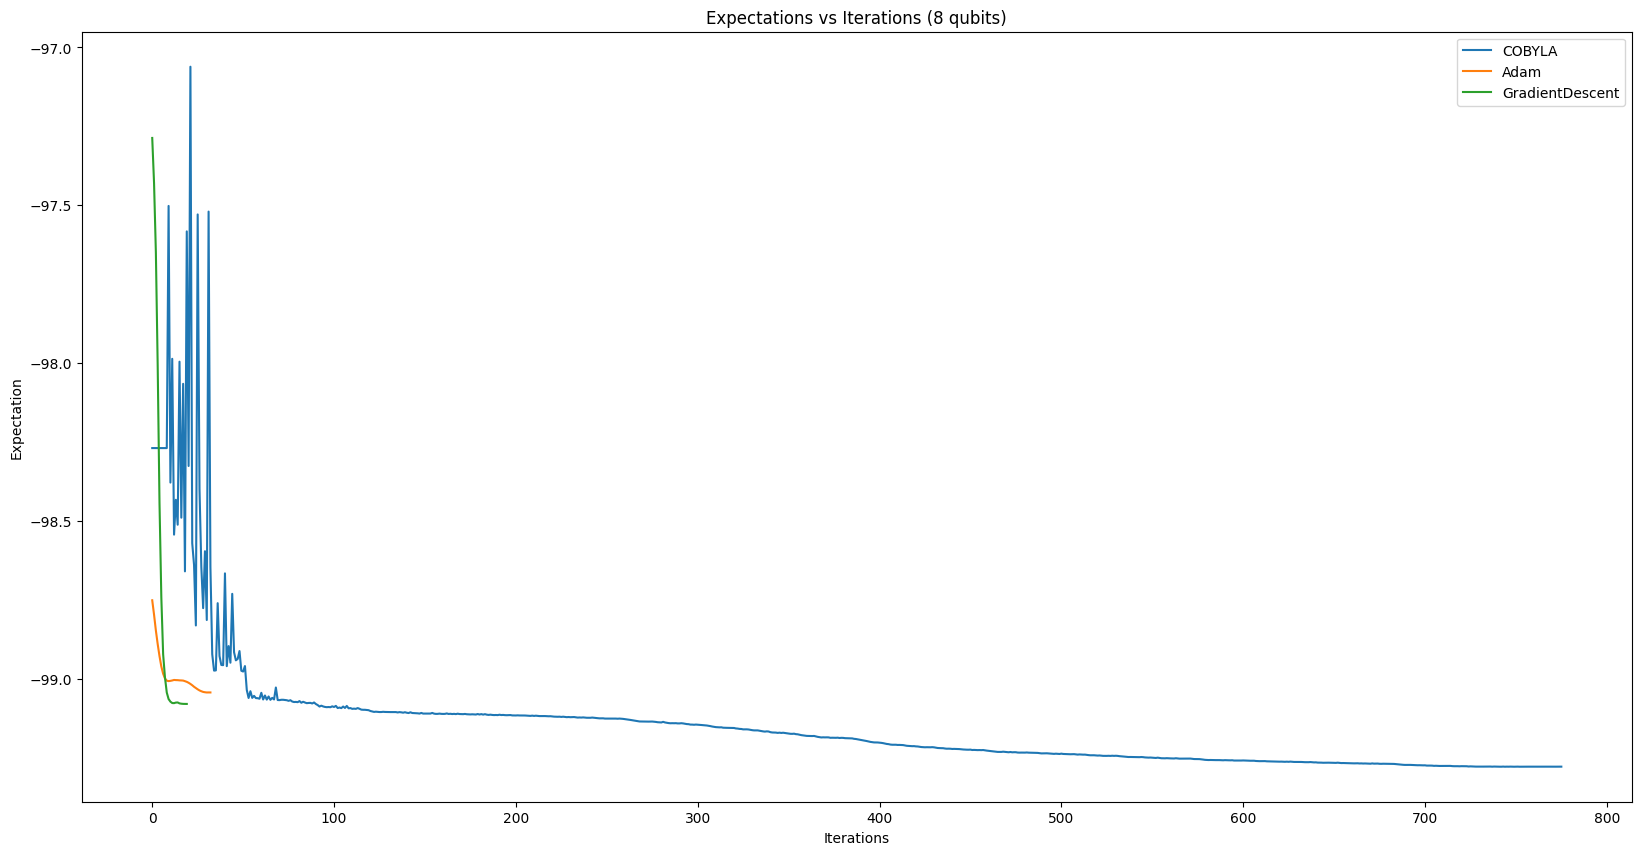

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()